# Monthly Climatology of EKE in NATL
$\frac{1}{2}(U^{'2} + V^{'2})$

CESM

In [1]:
from dask_gateway import Gateway
g = Gateway()
cluster = g.connect(g.list_clusters()[0].name)
client = cluster.get_client()

In [2]:
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.1f1f60cdcd4c40d389187f26d74596c5/status,


In [39]:
client.close()
cluster.close()

In [3]:
import xarray as xr
import numpy as np
import dask.array as dsa
import matplotlib.pyplot as plt
from fastjmd95 import jmd95numba, rho
import fastjmd95
import gcsfs
import gcm_filters
import xgcm
from typing import Annotated
#import gsw

In [4]:
from intake import open_catalog

url = "https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/GFDL_CM2.6.yaml"
cat = open_catalog(url)
ds  = cat["GFDL_CM2_6_control_ocean"].to_dask()
surf_ds  = cat["GFDL_CM2_6_control_ocean_surface"].to_dask()
coord  = cat["GFDL_CM2_6_grid"].to_dask()

/srv/conda/envs/notebook/lib/python3.10/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


In [5]:
import json
with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

rho1 = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CM2_6/datasets/surf_ds/rho.zarr'))
mask = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CM2_6/datasets/outliers_rm/mask.zarr'))

## MASK

In [6]:
atl_mask = mask.mask==0
selection = dict(xt_ocean=slice(-100, 30), yt_ocean=slice(-10, None))

## Rho contour

In [7]:
from fastjmd95 import jmd95numba

In [8]:
salt = ds.salt.where(atl_mask)#.sel(**selection).isel(st_ocean=0)
temp = ds.temp.where(atl_mask)#.sel(**selection).isel(st_ocean=0)
rho = jmd95numba.rho(salt, temp, 0)
rho0 = rho1.rho_test
delta_rho = 0.1
rho_bins = np.arange(1015, 1030, delta_rho)
selection = dict(xt_ocean=slice(-100, 30), yt_ocean=slice(-10, None))

/srv/conda/envs/notebook/lib/python3.10/site-packages/dask/array/core.py:4830: PerformanceWarning: Increasing number of chunks by factor of 64
  result = blockwise(
/srv/conda/envs/notebook/lib/python3.10/site-packages/dask/array/core.py:4830: PerformanceWarning: Increasing number of chunks by factor of 64
  result = blockwise(


In [9]:
rho_bins[117]

1026.7000000000025

In [10]:
rho_gb = rho0.groupby('time.month').mean('time')

In [11]:
rho_gb

<xarray.DataArray 'rho_test' (month: 12, yt_ocean: 2700, xt_ocean: 3600)>
dask.array<transpose, shape=(12, 2700, 3600), dtype=float64, chunksize=(1, 2700, 3600), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
  * month     (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

## EKE

In [12]:
#create grid obj to interp dxu/dyu to xt/yt_ocean coordinates for dx_min_POP
import xgcm
grid = xgcm.Grid(ds, coords={'X': {'center': 'xt_ocean', 'right': 'xu_ocean'},
                        'Y': {'center': 'yt_ocean', 'right': 'yu_ocean'},
                        'Z': {'inner': 'st_ocean', 'outer': 'st_edges_ocean'} }, periodic=['X'])

In [13]:
atl_mask_u = grid.interp(atl_mask, ['X', 'Y'])
selection_u = dict(xu_ocean=slice(-100, 30), yu_ocean=slice(-10, None))

In [14]:
up = (surf_ds.usurf.where(atl_mask_u).sel(**selection_u).groupby('time.month').mean('time') - 
       surf_ds.usurf.where(atl_mask_u).sel(**selection_u).groupby('time.month'))
vp = (surf_ds.vsurf.where(atl_mask_u).sel(**selection_u).groupby('time.month').mean('time') - 
       surf_ds.vsurf.where(atl_mask_u).sel(**selection_u).groupby('time.month'))

/srv/conda/envs/notebook/lib/python3.10/site-packages/dask/array/core.py:4830: PerformanceWarning: Increasing number of chunks by factor of 64
  result = blockwise(
/srv/conda/envs/notebook/lib/python3.10/site-packages/dask/array/core.py:4830: PerformanceWarning: Increasing number of chunks by factor of 64
  result = blockwise(
/srv/conda/envs/notebook/lib/python3.10/site-packages/xarray/core/indexing.py:1443: PerformanceWarning: Slicing with an out-of-order index is generating 20 times more chunks
  return self.array[key]
/srv/conda/envs/notebook/lib/python3.10/site-packages/dask/array/core.py:4830: PerformanceWarning: Increasing number of chunks by factor of 64
  result = blockwise(
/srv/conda/envs/notebook/lib/python3.10/site-packages/dask/array/core.py:4830: PerformanceWarning: Increasing number of chunks by factor of 64
  result = blockwise(
/srv/conda/envs/notebook/lib/python3.10/site-packages/xarray/core/indexing.py:1443: PerformanceWarning: Slicing with an out-of-order index is

In [15]:
up

<xarray.DataArray 'usurf' (time: 7305, yu_ocean: 1556, xu_ocean: 1300)>
dask.array<sub, shape=(7305, 1556, 1300), dtype=float32, chunksize=(1, 338, 450), chunktype=numpy.ndarray>
Coordinates:
  * xu_ocean  (xu_ocean) float64 -99.9 -99.8 -99.7 -99.6 ... 29.7 29.8 29.9 30.0
  * yu_ocean  (yu_ocean) float64 -9.95 -9.851 -9.753 -9.654 ... 89.92 89.96 90.0
    month     (time) int64 1 1 1 1 1 1 1 1 1 1 ... 12 12 12 12 12 12 12 12 12 12
  * time      (time) object 0181-01-01 12:00:00 ... 0200-12-31 12:00:00

In [16]:
rho_gb_i = grid.interp(rho_gb, ['X', 'Y'])
rho_gb = rho_gb_i.where(atl_mask_u).sel(**selection_u)

/srv/conda/envs/notebook/lib/python3.10/site-packages/dask/array/core.py:4830: PerformanceWarning: Increasing number of chunks by factor of 12
  result = blockwise(


In [17]:
rho_gb

<xarray.DataArray 'rho_test' (month: 12, yu_ocean: 1556, xu_ocean: 1300)>
dask.array<getitem, shape=(12, 1556, 1300), dtype=float64, chunksize=(1, 338, 450), chunktype=numpy.ndarray>
Coordinates:
  * xu_ocean  (xu_ocean) float64 -99.9 -99.8 -99.7 -99.6 ... 29.7 29.8 29.9 30.0
  * yu_ocean  (yu_ocean) float64 -9.95 -9.851 -9.753 -9.654 ... 89.92 89.96 90.0
Dimensions without coordinates: month

In [18]:
eke = 0.5 * (up**2 + vp**2)

In [19]:
eke_clim = eke.groupby('time.month').mean('time')

In [20]:
eke_clim

<xarray.DataArray (month: 12, yu_ocean: 1556, xu_ocean: 1300)>
dask.array<transpose, shape=(12, 1556, 1300), dtype=float32, chunksize=(1, 338, 450), chunktype=numpy.ndarray>
Coordinates:
  * xu_ocean  (xu_ocean) float64 -99.9 -99.8 -99.7 -99.6 ... 29.7 29.8 29.9 30.0
  * yu_ocean  (yu_ocean) float64 -9.95 -9.851 -9.753 -9.654 ... 89.92 89.96 90.0
  * month     (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [21]:
eke_clim.sel(month=3)

<xarray.DataArray (yu_ocean: 1556, xu_ocean: 1300)>
dask.array<getitem, shape=(1556, 1300), dtype=float32, chunksize=(338, 450), chunktype=numpy.ndarray>
Coordinates:
  * xu_ocean  (xu_ocean) float64 -99.9 -99.8 -99.7 -99.6 ... 29.7 29.8 29.9 30.0
  * yu_ocean  (yu_ocean) float64 -9.95 -9.851 -9.753 -9.654 ... 89.92 89.96 90.0
    month     int64 3

In [22]:
rho_gb.sel(month=3)

<xarray.DataArray 'rho_test' (yu_ocean: 1556, xu_ocean: 1300)>
dask.array<getitem, shape=(1556, 1300), dtype=float64, chunksize=(338, 450), chunktype=numpy.ndarray>
Coordinates:
  * xu_ocean  (xu_ocean) float64 -99.9 -99.8 -99.7 -99.6 ... 29.7 29.8 29.9 30.0
  * yu_ocean  (yu_ocean) float64 -9.95 -9.851 -9.753 -9.654 ... 89.92 89.96 90.0

/srv/conda/envs/notebook/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 12.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


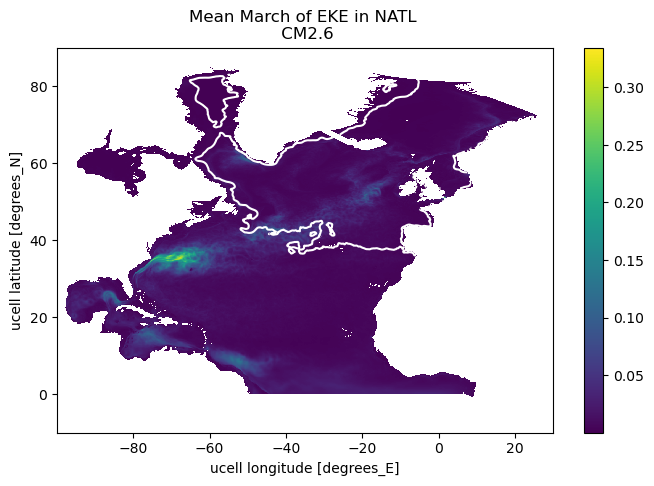

In [23]:
fig, ax0 = plt.subplots(figsize=(8,5))

eke_clim.sel(month=3).plot(ax=ax0)
rho_gb.sel(month=3).plot.contour(colors='white', levels=[rho_bins[117]], ax=ax0,) 
                                 #cbar_kwargs={'shrink':0.8, 'label':r'[m^2 s$^{-2}$]'})

plt.title('Mean March of EKE in NATL \n CM2.6');

# RMS
the square root of the mean of the squared values of elements of y in $y = m(x) + b$

In [24]:
import json
with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

#natl_surf = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CM2_6/datasets/surf/natl_ocean_surf_tends.zarr'))
natl = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CM2_6/datasets/outliers_rm/natl_ocean.zarr'))
rho = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CM2_6/datasets/surf_ds/rho.zarr'))

In [25]:
natl

<xarray.Dataset>
Dimensions:         (time: 7305, yt_ocean: 2700, xt_ocean: 3600)
Coordinates:
    geolat_t        (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolon_t        (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    lat             (yt_ocean, xt_ocean) float32 dask.array<chunksize=(338, 450), meta=np.ndarray>
    lon             (yt_ocean, xt_ocean) float32 dask.array<chunksize=(338, 450), meta=np.ndarray>
    st_ocean        float64 ...
  * time            (time) object 0181-01-01 12:00:00 ... 0200-12-31 12:00:00
  * xt_ocean        (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.85 79.95
  * yt_ocean        (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.94 89.98
Data variables:
    NATL_cabbeling  (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    NATL_rho_lap    (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    NATL_sss        (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    NATL_sst        (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>

In [26]:
def rms(da):
    rms = ((da**2).groupby('time.month').mean('time'))**0.5
    return rms

In [40]:
def plot_contours_tend_terms(axis, tend_term):
    """Plot surface density contours and tendency terms"""
    c = rho_gb.sel(month=3).plot.contour(colors='white', levels=[rho_bins[117]], ax=axis)
    
    selection = dict(xt_ocean=slice(-100, 30), yt_ocean=slice(-10, None))
    kwargs = {'shrink': 0.8, 'label':r'[$\frac{kg}{m^3 s}$]'}
    rms(tend_term).where(atl_mask).sel(**selection).sel(month=3).plot(robust=True, ax=axis,
                                                                       cbar_kwargs=kwargs)

In [ ]:
#plot all four terms
fig, ax = plt.subplots(2,2, figsize=(16,10))

plot_contours_tend_terms(ax[0,0], natl.NATL_sst)
ax[0,0].set_title('SST mixing tendency')

plot_contours_tend_terms(ax[0,1], natl.NATL_sss)
ax[0,1].set_title('SSS mixing tendency')

plot_contours_tend_terms(ax[1,0], natl.NATL_rho_lap)
ax[1,1].set_title(r'$\rho$ mixing tendency')

plot_contours_tend_terms(ax[1,1], natl.NATL_cabbeling)
ax[1,1].set_title('Cabbeling tendency')

plt.suptitle('Mean March RMS \n CM2.6', fontsize=16)
plt.tight_layout();

/srv/conda/envs/notebook/lib/python3.10/site-packages/dask/array/core.py:4830: PerformanceWarning: Increasing number of chunks by factor of 12
  result = blockwise(
/srv/conda/envs/notebook/lib/python3.10/site-packages/dask/array/core.py:4830: PerformanceWarning: Increasing number of chunks by factor of 12
  result = blockwise(
/srv/conda/envs/notebook/lib/python3.10/site-packages/dask/array/core.py:4830: PerformanceWarning: Increasing number of chunks by factor of 12
  result = blockwise(


In [54]:
client.close()
cluster.close()